# Analysis: TMI

In [1]:
import Modularized_Data_Processing as mdp
import mne
import glob

filepath = r"C:\Users\Owner\OneDrive - Regis University\laryngeal_bci\data\fifs\second_try\BCIproject_trial-N-1.2-11-2021_raw.fif.gz"

PATH1 = r"C:\Users\Owner\OneDrive - Regis University\laryngeal_bci\data\fifs\\"
PATH2 = r"C:\Users\words\OneDrive - Regis University\laryngeal_bci\data\fifs\\"
FIRST_TRY = "/first_try/"
SECOND_TRY = "/second_try/"
PATH = PATH1 + SECOND_TRY
FILENAME1 = PATH + FIRST_TRY + "BCIproject_trial-S5_raw.fif.gz"
FILENAME2 = PATH + "BCIproject_trial-S3_raw.fif.gz"
FILENAME3 = PATH + "BCIproject_trial-1.2-11-2021_raw.fif.gz"
FILENAME4 = PATH + "BCIproject_trial-S-3.3-25-2021_raw.fif.gz"
S_FILES = [f for f in glob.glob(PATH + '*S*raw.fif.gz')]
N_FILES = [f for f in glob.glob(PATH + '*N*raw.fif.gz')]
NEW_N_FILES = [f for f in glob.glob(PATH + '*N-*raw.fif.gz')]
ALL_FILES = [f for f in glob.glob(PATH1 + '*raw.fif.gz')]
FILE = FILENAME4
FILENAMES = ALL_FILES

#Load data
# data = mdp.load_data(FILE)

data = mdp.load_many_data(FILENAMES)

Opening raw data file C:\Users\Owner\OneDrive - Regis University\laryngeal_bci\data\fifs\BCIproject_trial-N-1.2-22-2021_raw.fif.gz...
    Range : 0 ... 449998 =      0.000 ...   449.998 secs
Ready.
Reading 0 ... 449998  =      0.000 ...   449.998 secs...
Opening raw data file C:\Users\Owner\OneDrive - Regis University\laryngeal_bci\data\fifs\BCIproject_trial-N-2.2-22-2021_raw.fif.gz...
    Range : 0 ... 441829 =      0.000 ...   441.829 secs
Ready.
Reading 0 ... 441829  =      0.000 ...   441.829 secs...
Opening raw data file C:\Users\Owner\OneDrive - Regis University\laryngeal_bci\data\fifs\BCIproject_trial-N-3.2-22-2021_raw.fif.gz...
    Range : 0 ... 449998 =      0.000 ...   449.998 secs
Ready.
Reading 0 ... 449998  =      0.000 ...   449.998 secs...
Opening raw data file C:\Users\Owner\OneDrive - Regis University\laryngeal_bci\data\fifs\BCIproject_trial-S-1.3-4-2021_raw.fif.gz...
    Range : 0 ... 449998 =      0.000 ...   449.998 secs
Ready.
Reading 0 ... 449998  =      0.000 ...

In [11]:
ALL_FILES

['C:\\Users\\Owner\\OneDrive - Regis University\\laryngeal_bci\\data\\fifs\\BCIproject_trial-N-1.2-22-2021_raw.fif.gz',
 'C:\\Users\\Owner\\OneDrive - Regis University\\laryngeal_bci\\data\\fifs\\BCIproject_trial-N-2.2-22-2021_raw.fif.gz',
 'C:\\Users\\Owner\\OneDrive - Regis University\\laryngeal_bci\\data\\fifs\\BCIproject_trial-N-3.2-22-2021_raw.fif.gz',
 'C:\\Users\\Owner\\OneDrive - Regis University\\laryngeal_bci\\data\\fifs\\BCIproject_trial-S-1.3-4-2021_raw.fif.gz',
 'C:\\Users\\Owner\\OneDrive - Regis University\\laryngeal_bci\\data\\fifs\\BCIproject_trial-S-2.3-8-2021_raw.fif.gz',
 'C:\\Users\\Owner\\OneDrive - Regis University\\laryngeal_bci\\data\\fifs\\BCIproject_trial-S-3.3-25-2021_raw.fif.gz']

In [2]:
#display raw data

chns = data.info.ch_names

picks = data.info.ch_names



chn_idxs = []
for chn in picks:
    chn_idxs.append(chns.index(chn))

#apply the bandpass filter

low_fq = 5
hi_fq = 40

crpd_data = data.crop(2)
cd_fd_data = data.filter(5, 50)   #I think this is redundant with In [4]: line 40

Filtering raw data in 6 contiguous segments
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1651 samples (1.651 sec)



In [3]:
epoch_type = "TMI-a"
event_idT = "True-" + epoch_type + "-"
event_idF = "False-" + epoch_type + "-"

f1, f2 = mdp.get_epochs(epoch_type, data, nperseg=2000, noverlap=1800, channels=picks) #f1_empty should be empty in the case of alpha waves (there are no false alpha wave trials); only look at f2

Used Annotations descriptions: ['False-TMI-a-']
30 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 30 events and 5001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['True-TMI-a-']
30 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 30 events and 5001 original time points ...
0 bad epochs dropped
true_found is: True


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

tmin, tmax = -1., 4.
event_id = dict(hands=0, feet=1)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet




raw_fnames = eegbci.load_data(subject, runs)


# raw_fnames = FILE


# I need to get raw objects to give to concatenate_raws

# raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
raw = data
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))

# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')



events, _ = events_from_annotations(raw, event_id={event_idT:0, event_idF:1}) #not sure why the type for event_idT or F is incorrect, maybe it has to be a dictionary 

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1]

Filtering raw data in 6 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Used Annotations descriptions: ['False-TMI-a-', 'True-TMI-a-']
60 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 60 events and 5001 original time points ...
0 bad epochs dropped


Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 16 dim * 2.7e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 16 dim * 3e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 16 dim * 2.8e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 16 dim * 2.9e+15  max singular value)
    Estimated rank (m

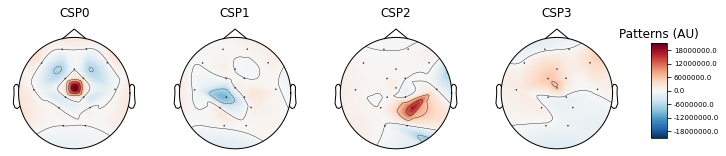

In [5]:
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

plt.show(csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5))

<generator object BaseShuffleSplit.split at 0x000002459C6EA190>
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 16 dim * 2.7e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 16 dim * 3e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
<generator object BaseShuffleSplit.split at 0x000002459C6EA190>
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 16 dim * 2.8e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing

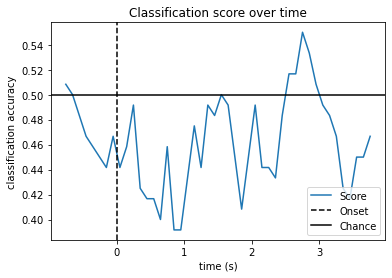

In [17]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    print(cv_split)
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

In [7]:
np.mean(scores_windows)

0.46213768115942033

# AUTO ML

In [9]:
import pandas as pd

X_train = csp.fit_transform(epochs_data, labels)

df = pd.DataFrame(data=X_train)
df['label'] = labels

Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 16 dim * 8.4e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 26 (2.2e-16 eps * 16 dim * 7.2e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.


In [10]:
df.shape

(60, 5)

### ways to improve accuracy
- breaking up the data (1/3) before csp
- deal with bad channels before csp analysis!!!
    -bad channels may need to be scaled by 0 instead of being dropped
- adding the csp to pycaret optimization

In [13]:
from pycaret.classification import setup, compare_models
clf1 = setup(data = df, target = 'label', fold=5)
# return best model
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.5917,0.5883,0.6333,0.5143,0.5486,0.1936,0.2018,0.0180
ada,Ada Boost Classifier,0.5639,0.5358,0.6000,0.4333,0.4865,0.1530,0.1655,0.0580
lightgbm,Light Gradient Boosting Machine,0.5611,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0260
nb,Naive Bayes,0.5417,0.5742,0.6167,0.5476,0.5410,0.1135,0.1316,0.0140
svm,SVM - Linear Kernel,0.5167,0.0000,0.7500,0.3750,0.4988,0.1028,0.1445,0.0180
gbc,Gradient Boosting Classifier,0.4944,0.3992,0.7000,0.4762,0.5403,0.0552,0.0801,0.0400
dt,Decision Tree Classifier,0.4667,0.4967,0.5833,0.4405,0.4776,-0.0060,-0.0265,0.0120
lr,Logistic Regression,0.4611,0.5092,0.2833,0.2333,0.2460,-0.1022,-0.1370,0.0160
ridge,Ridge Classifier,0.4389,0.0000,0.2833,0.2133,0.2349,-0.1417,-0.1770,0.0160
lda,Linear Discriminant Analysis,0.4389,0.4758,0.2833,0.2133,0.2349,-0.1417,-0.1770,0.0120


In [14]:
best

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [ ]:
epochs_data

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

# try grid search and bayes search pycaret

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.1,
          'loss': 'exponential'}


scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
gbr = GradientBoostingClassifier(**params).fit(X_train, y_train)
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('GBR', gbr)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

plt.show(csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5))

ValueError: Found input variables with inconsistent numbers of samples: [60, 48]

ValueError: x and y must have same first dimension, but have shapes (46,) and (1,)

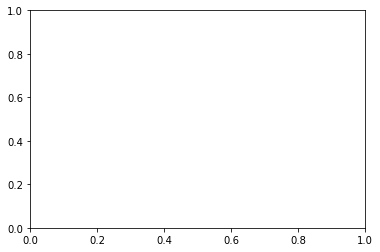

In [15]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train) #maybe also optimize csp
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    best.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(best.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

In [ ]:
np.mean(scores_windows)